In [1]:
import torch
import numpy as np
import string
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
CONTEXT_LENGTH = 3
SPECIAL = '.'

## Class and functions definitions

In [2]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, X, Y):
        super().__init__()
        assert(X.shape[0] == Y.shape[0])
        self.X, self.Y = X, Y

    def __getitem__(self, idx):
        return self.X[idx, ...], self.Y[idx, ...]

    def __len__(self):
        return self.X.shape[0]

In [3]:
def build_dataset_from_names(names: list, context_length: int, special_char: str):
    """
    Build dataset 
    """
    X = list()
    Y = list()
    prepend = "".join([special_char for i in range(context_length)])
    for n in names:
        n_ext = "".join([prepend, n, special_char])
        for i in range(len(n_ext) - context_length):
            x = n_ext[i:i + context_length]
            Y.append(chars_to_int[n_ext[i + context_length]])
            X.append([chars_to_int[c] for c in x])
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [87]:
class MLP(torch.nn.Module):

    def __init__(self, num_embeddings: int ,embedding_dim: int, hidden_dim: int, 
                 context_length: int, char_to_int: dict, original_architecture: bool = False):
        """
        Neural Probabilistic model as defined in the paper from Bengio. It is slightly different
        from what is described in the paper, since there are no skip connections between embedding
        and ouput layer.

        Parameters
        num_embeddings: number of embeddings
        embedding_dim: embedding dimension
        hidden_dim: dimension of the hidden layer
        context_length: number of characters to use for prediction
        char_to_int: mapping character -> int
        paper_architecture: if True add the skip connections as in the original paper
        """
        super().__init__()
        self.context_length = context_length
        self.embedding_dim = embedding_dim
        self.char_to_int = char_to_int
        self.int_to_char = {v: k for k, v in self.char_to_int.items()}
        self.original_architecture = original_architecture
        self.embedding = torch.nn.Embedding(num_embeddings, embedding_dim)
        self.hidden_layer = torch.nn.Linear(in_features=embedding_dim * context_length, 
                                            out_features=hidden_dim)

        self.hidden_activation = torch.nn.Tanh()
        if self.original_architecture:
            output_dim = hidden_dim + embedding_dim * context_length 
        else:
            output_dim = hidden_dim
            
        self.output_layer = torch.nn.Linear(in_features=output_dim, out_features=num_embeddings)
        self.output_activation = torch.nn.Softmax(dim=1)

    def forward(self, X):
        """
        Forward pass outputs unnormalized logits
        """
        C = self.embedding(X).view(-1, self.context_length * self.embedding_dim)
        out = self.hidden_layer(C)
        out = self.hidden_activation(out)
        if self.original_architecture:
            out = torch.cat([C, out], dim=1)
        out = self.output_layer(out)
        return out

    def predict_proba(self, X):
        """
        Predict next char proabilities
        """
        logits = self(X)
        return self.output_activation(logits)

    def generate_name(self, generator=None):
        with torch.no_grad():
            res = ""
            start = torch.tensor([[self.char_to_int[c] for c in SPECIAL * self.context_length]])
            next_char = ""
            while next_char != chars_to_int[SPECIAL]:
                probs = model.predict_proba(start)
                next_char = torch.multinomial(probs, num_samples=1, generator=generator)
                res += self.int_to_char[next_char.item()]
                new_start = torch.tensor([[c for c in start[0, 1:]] + [next_char]])
                start = new_start
        return res
        

In [5]:
def regularization(model):
    """
    Regularization loss as described in the paper
    """
    C = list(model.embedding.parameters())[0]
    W = list(model.hidden_layer.parameters())[0]
    O = list(model.hidden_layer.parameters())[0]
    return (C**2).sum() + (W**2).sum() + (O**2).sum()

## Create data

In [7]:
names = np.array(open("data/names_usa.txt").read().splitlines())

In [8]:
generator = torch.Generator().manual_seed(42)

In [9]:
chars = string.ascii_lowercase + SPECIAL
chars_to_int = {c: k for k,c in enumerate(chars)}
int_to_chars = {k: c for c, k in chars_to_int.items()}

In [10]:
n_names = len(names)
idx = torch.randperm(n_names, generator=generator)
tr_idx = idx[:int(n_names*0.8)]
dev_idx = idx[int(n_names*0.8):int(n_names*0.9)]
te_idx = idx[int(n_names*0.9):]

Xtr, Ytr = build_dataset_from_names(names[tr_idx], 
                               context_length=CONTEXT_LENGTH, 
                               special_char=SPECIAL)

Xdev, Ydev = build_dataset_from_names(names[dev_idx], 
                               context_length=CONTEXT_LENGTH, 
                               special_char=SPECIAL)

Xte, Yte = build_dataset_from_names(names[te_idx], 
                               context_length=CONTEXT_LENGTH, 
                               special_char=SPECIAL)

## Model

### Parameters

In [82]:
model_parameters = {
    "num_embeddings": len(chars),
    "embedding_dim": 15,
    "hidden_dim": 60,
    "context_length": CONTEXT_LENGTH,
    "char_to_int": chars_to_int,
    "original_architecture": False
}

epochs = 60
batch_size = 32
loss = torch.nn.CrossEntropyLoss()

### Learning rate search

In [88]:
model = MLP(**model_parameters)
lre = torch.linspace(-3, 0, 1000)
lri = 10 ** lre

stats = list()

for lr in lri:
    idx = torch.randperm(Xtr.shape[0], generator=generator)[:batch_size]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    yhat = model(Xtr[idx, ...])
    l = loss(yhat.float(), Ytr[idx]) #+ regularization(model)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()

    stats.append(l.item())

(-3.0, 0.0)

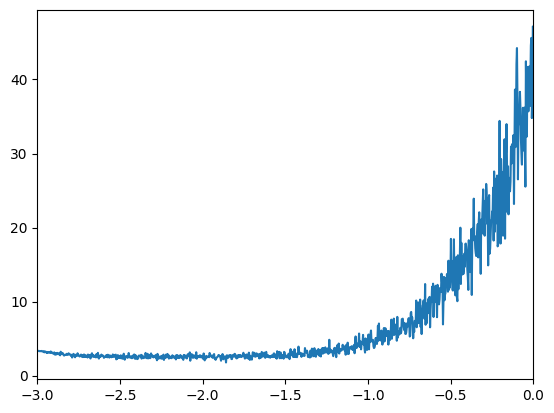

In [89]:
plt.plot(lre, stats)
plt.xlim(-3, 0)
#plt.yscale("log")

### Training

In [90]:
model = MLP(**model_parameters)

data_loader = torch.utils.data.DataLoader(
    Dataset(Xtr, Ytr), 
    batch_size=batch_size, 
    shuffle=True, 
    generator=generator
)

optimizer = torch.optim.Adam(model.parameters(), lr=10**(-2))
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(
    optimizer, lr_lambda=lambda x: 0.9 if x % 3 == 0 and x > 0 else 1.)

epochs = 60
for e in range(epochs):
    for x, y in data_loader:
        
        optimizer.zero_grad()
        yhat = model(x)
        l = loss(yhat.float(), y)
        l.backward()
        optimizer.step()
        
    with torch.no_grad():
        yhat = model(Xtr)
        ltr = loss(yhat.float(), Ytr)
        yhat_dev = model(Xdev)
        ldev = loss(yhat_dev.float(), Ydev)
        print(f"Epoch {e}: loss {ltr.item():.4f} {ldev.item():.4f}")
    scheduler.step()

Epoch 0: loss 2.3009 2.3196
Epoch 1: loss 2.2876 2.3166
Epoch 2: loss 2.2721 2.3019
Epoch 3: loss 2.2478 2.2805
Epoch 4: loss 2.2622 2.2947
Epoch 5: loss 2.2613 2.2965
Epoch 6: loss 2.2289 2.2584
Epoch 7: loss 2.2379 2.2647
Epoch 8: loss 2.2338 2.2738
Epoch 9: loss 2.2197 2.2608
Epoch 10: loss 2.2193 2.2598
Epoch 11: loss 2.2115 2.2474
Epoch 12: loss 2.2123 2.2568
Epoch 13: loss 2.2069 2.2498
Epoch 14: loss 2.2013 2.2420
Epoch 15: loss 2.1913 2.2286
Epoch 16: loss 2.1904 2.2340
Epoch 17: loss 2.1926 2.2414
Epoch 18: loss 2.1774 2.2205
Epoch 19: loss 2.1776 2.2226
Epoch 20: loss 2.1765 2.2241
Epoch 21: loss 2.1680 2.2156
Epoch 22: loss 2.1747 2.2160
Epoch 23: loss 2.1602 2.2084
Epoch 24: loss 2.1664 2.2160
Epoch 25: loss 2.1603 2.2048
Epoch 26: loss 2.1583 2.2032
Epoch 27: loss 2.1523 2.2004
Epoch 28: loss 2.1529 2.2046
Epoch 29: loss 2.1464 2.1991
Epoch 30: loss 2.1362 2.1865
Epoch 31: loss 2.1384 2.1874
Epoch 32: loss 2.1429 2.1960
Epoch 33: loss 2.1388 2.1883
Epoch 34: loss 2.1302 2.

### Evaluation

In [91]:
with torch.no_grad():
    yhat = model(Xtr)
    ltr = loss(yhat.float(), Ytr)
    yhat_dev = model(Xdev)
    ldev = loss(yhat_dev.float(), Ydev)
    yhat_te = model(Xte)
    lte = loss(yhat_te.float(), Yte)
    print(f"Loss: train {ltr.item():.4f} dev {ldev.item():.4f} test {lte:.4f}")

Loss: train 2.1012 dev 2.1623 test 2.1626


## Generate new names

In [93]:
for _ in range(10):
    print(model.generate_name(generator=generator))

keli.
jia.
alee.
awin.
hano.
liah.
liphine.
mari.
alo.
bechi.
